# ADE13: Estadísticos de Asociación Espacial Local (Getis-Ord $G_i^*$)

## En esta notebook...

Habiendo explorado estadísticos globales de autocorrelación espacial (como el índice I de Moran) que resumen el patrón espacial de todo el mapa en un único número, ahora daremos el siguiente paso fundamental: los **estadísticos locales**. Estos nos permiten no solo detectar la presencia de autocorrelación espacial, sino identificar la **ubicación específica** de los clusters en el territorio.

Introduciremos la familia de estadísticos $G$ de Getis y Ord, la herramienta fundamental para lo que se conoce como **"Hotspot Analysis"** o análisis de puntos calientes. A diferencia de los estadísticos de similitud (como LISA), los estadísticos $G$ están diseñados específicamente para identificar concentraciones espaciales de valores **altos** (hotspots) y valores **bajos** (coldspots), distinguiendo entre ambos.

<!-- ---

## Índice

1. El Problema: Estadísticos Globales vs. Locales
2. Teoría: La Familia de Estadísticos $G$
3. El Estadístico $G_i(d)$ (Excluyente)
4. El Estadístico $G_i^*(d)$ (Incluyente)
5. Inferencia e Interpretación: Puntuación Z
6. Comparativa Clave: $G_i^*$ vs. Moran's I Local
7. Taller Práctico: Análisis de Hotspots en Python
8. Paso 1: Carga y Preparación de Datos (Viviendas San Diego)
9. Paso 2: Creación de Pesos Espaciales por Distancia
10. Paso 3: Cálculo de $G_i^*$ con `esda`
11. Paso 4: Visualización e Interpretación (Hotspots y Coldspots)
12. Conclusiones

--- -->

## Instalación de Dependencias

Si es la primera vez que ejecutas esta notebook, necesitas instalar las librerías de PySAL. Descomenta y ejecuta la siguiente celda:

In [18]:
# !pip install geopandas
# !pip install libpysal
# !pip install esda
# !pip install rasterio

## Importación de Bibliotecas

Además de nuestras bibliotecas habituales (`geopandas`, `matplotlib`), hoy sumaremos dos componentes clave de la familia **PySAL** (Python Spatial Analysis Library):

- **`libpysal.weights`**: Para la creación de matrices de pesos espaciales basadas en criterios de proximidad (distancia, contigüidad, etc.).
- **`esda`** (Exploratory Spatial Data Analysis): Contiene las implementaciones de los estadísticos de autocorrelación espacial, tanto globales como locales, incluyendo los estadísticos $G_i$ y $G_i^*$ de Getis-Ord.

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import libpysal.weights as weights
import esda

# Configuración de visualización
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.precision', 3)

---
# PARTE I: MARCO TEÓRICO
---

## 1. El Problema: Estadísticos Globales vs. Locales

### La Limitación de los Estadísticos Globales

Los estadísticos globales de autocorrelación espacial, como el índice I de Moran global o el estadístico $G(d)$ global, condensan toda la información espacial de un mapa en un **único número**. Este valor nos indica si existe autocorrelación espacial en el conjunto de datos, pero presenta una limitación crítica: **no puede identificar *dónde* están ubicados los clusters**.

Por ejemplo, un valor de I de Moran global positivo nos dice que hay autocorrelación positiva (valores similares están agrupados), pero no nos dice:
- ¿Cuáles son las regiones que forman clusters?
- ¿Son clusters de valores altos o de valores bajos?
- ¿Hay múltiples clusters o solo uno?

### El Peligro de Ignorar la Autocorrelación

El fracaso en tener en cuenta la autocorrelación espacial puede llevar a serios errores de interpretación en análisis estadísticos. Sin estadísticos locales, podemos pasar por alto patrones espaciales críticos que tienen implicaciones teóricas y prácticas importantes.

### La Solución: Estadísticos Locales

El objetivo de los estadísticos $G$ es, precisamente, detectar "bolsones" (*pockets*) locales de dependencia espacial que pueden no ser evidentes al usar un estadístico global. Estos estadísticos nos permiten responder la pregunta: **"¿Dónde están los clusters y qué características tienen?"**

## 2. Teoría: La Familia de Estadísticos $G$

La familia de estadísticos $G$ de Getis y Ord constituye una medida de asociación espacial diseñada específicamente para analizar la concentración de valores de una variable $X$ en el espacio.

### Requisito Fundamental de los Datos

Un requisito clave para aplicar estos estadísticos es que **la variable debe tener un origen natural y ser positiva**. Esto incluye variables como:
- Precios de viviendas
- Tasas de enfermedad o mortalidad
- Conteos de eventos (crímenes, accidentes)
- Ingresos o salarios
- Densidades poblacionales

Variables que pueden tomar valores negativos o que son diferencias (sin origen natural) no son apropiadas para estos estadísticos.

### Matriz de Pesos Espaciales

El estadístico $G$ se basa en una **matriz de pesos espaciales** $w_{ij}(d)$ que define qué ubicaciones $j$ están "cerca" de la ubicación $i$. El parámetro $d$ representa una **distancia umbral**: dos ubicaciones se consideran vecinas si están dentro de una distancia $d$.

Esta matriz define la **estructura de vecindad** que usaremos para evaluar si los valores de $X$ en ubicaciones cercanas están concentrados (son todos altos o todos bajos) o dispersos.

## 3. El Estadístico $G_i(d)$ (Excluyente)

### Definición

El estadístico $G_i(d)$ se define como:

$$G_{i}(d)=\frac{\sum_{j=1}^{n}w_{ij}(d)x_{j}}{\sum_{j=1}^{n}x_{j}}, \quad j \neq i$$

### Componentes de la Fórmula

Vamos a descomponer cada elemento de esta expresión:

- **$w_{ij}(d)$**: Es una matriz de pesos espaciales binaria (simétrica), donde $w_{ij}=1$ si la ubicación $j$ está dentro de una distancia $d$ de la ubicación $i$, y $w_{ij}=0$ si no lo está.

- **$x_j$**: Es el valor de la variable de interés en la ubicación $j$.

- **$j \neq i$**: Esta condición es **crítica**. Esta versión del estadístico **excluye** el valor del propio punto $i$ (es decir, $x_i$) tanto del numerador como del denominador. Por eso se le llama la versión "excluyente".

- **Numerador**: Suma los valores de $X$ en los vecinos de $i$ (dentro de la distancia $d$).

- **Denominador**: Suma de todos los valores de $X$ en el conjunto de datos (excluyendo $x_i$).

### Interpretación Intuitiva

El estadístico $G_i$ compara la proporción de la suma total de $X$ que se concentra en el vecindario de $i$. Si esta proporción es significativamente mayor de lo esperado por azar, indica un **hotspot** (concentración de valores altos).

### Hipótesis Nula

La hipótesis nula ($H_0$) es la **independencia espacial**. Bajo $H_0$, cualquier permutación de los valores $x_j$ (excepto $x_i$, que se mantiene fijo en su ubicación) es igualmente probable. Esto significa que no hay razón para esperar que los valores en el vecindario de $i$ sean sistemáticamente más altos o más bajos que en cualquier otra parte.

### Distribución Teórica: Expectativa y Varianza

Para realizar inferencia estadística, necesitamos conocer la distribución de $G_i$ bajo la hipótesis nula. Getis y Ord derivan las fórmulas para la expectativa y la varianza:

**Expectativa:**

$$E(G_{i}) = \frac{W_i}{(n-1)}$$

**Varianza:**

$$\text{Var}(G_{i})=\frac{W_{i}(n-1-W_{i})}{(n-1)^{2}(n-2)}\left(\frac{Y_{i2}}{Y_{i1}^{2}}\right)$$

Donde:

- $W_i = \sum_{j} w_{ij}$ (suma de los pesos para la ubicación $i$, es decir, el número de vecinos)
- $Y_{i1} = \sum_{j \neq i} x_j$ (suma de todos los valores excepto $x_i$)
- $Y_{i2} = \sum_{j \neq i} x_j^2$ (suma de los cuadrados de todos los valores excepto $x_i$)

## 4. El Estadístico $G_i^*(d)$ (Incluyente)

Existe una variación del estadístico $G_i$ que es **más utilizada en la práctica**: el estadístico $G_i^*(d)$. Esta es la versión que encontraremos implementada en librerías como `esda`.

La diferencia fundamental entre $G_i$ y $G_i^*$ es que esta última versión **incluye** el valor del propio punto $i$ en el análisis. Es decir, en la fórmula, ahora $j$ **puede** ser igual a $i$. Por eso se le llama la versión "incluyente" o "con estrella" (*star*).

### Fórmulas para $G_i^*(d)$

Las fórmulas correspondientes a $G_i^*$ (Tabla 1 del paper) son:

**Estadístico:**

$$G_{i}^{*}(d)=\frac{\sum_{j}w_{ij}(d)x_{j}}{\sum_{j}x_{j}}$$

Notar que ahora la sumatoria del numerador incluye todos los $j$ (incluyendo $i$), y el denominador es la suma de **todos** los valores de $X$.

$$E(G_{i}^{*}) = \frac{W_i^*}{n}$$

$$\text{Var}(G_{i}^{*})=\frac{W_{i}^{*}(n-W_{i}^{*})Y_{i2}^{*}}{n^{2}(n-1)(Y_{i1}^{*})^{2}}$$

Donde:
- $W_i^* = \sum_{j} w_{ij} + 1$ (suma de los pesos incluyendo al propio $i$)
- $Y_{i1}^* = \sum_{j} x_j$ (suma de **todos** los valores, incluyendo $x_i$)
- $Y_{i2}^* = \sum_{j} x_j^2$ (suma de los cuadrados de **todos** los valores)

### ¿Por qué usar $G_i^*$?

La versión $G_i^*$ es generalmente preferida porque:

1. **Incluye toda la información**: El valor del punto focal $i$ es parte del análisis, lo cual tiene sentido si queremos identificar si ese punto pertenece a un hotspot o coldspot.

2. **Más poder estadístico**: Al incluir más información (el valor de $x_i$), el estadístico puede detectar patrones con mayor sensibilidad.

3. **Interpretación más intuitiva**: Preguntamos "¿el punto $i$ y sus vecinos forman un cluster de valores altos/bajos?" en lugar de "¿los vecinos de $i$ (sin incluir a $i$) forman un cluster?".

En el resto de este notebook, trabajaremos con $G_i^*$, que es la versión estándar para "Hotspot Analysis".

## 5. Inferencia e Interpretación: Puntuación Z

Para determinar si un valor de $G_i^*$ es estadísticamente significativo, lo estandarizamos calculando su **puntuación Z** (Z-score):

$$Z(G_{i}^{*}) = \frac{G_{i}^{*} - E(G_{i}^{*})}{\sqrt{\text{Var}(G_{i}^{*})}}$$

Esta puntuación Z nos dice cuántas desviaciones estándar está el valor observado de $G_i^*$ respecto a su expectativa bajo la hipótesis nula.

### Interpretación de la Puntuación Z

- **$Z > 0$**: El valor de $G_i^*$ es mayor que su expectativa. Esto sugiere que la ubicación $i$ y sus vecinos tienen valores **más altos** que el promedio del conjunto de datos.

- **$Z < 0$**: El valor de $G_i^*$ es menor que su expectativa. Esto sugiere que la ubicación $i$ y sus vecinos tienen valores **más bajos** que el promedio.

- **$|Z|$ grande**: Cuanto mayor sea el valor absoluto de $Z$, más fuerte es la evidencia contra la hipótesis nula de independencia espacial.

### Clasificación de Hotspots y Coldspots

Usando umbrales de significancia estadística (típicamente $\alpha = 0.05$ o $\alpha = 0.01$), podemos clasificar cada ubicación:

| Puntuación Z | Interpretación | Clasificación |
|--------------|----------------|---------------|
| $Z > 1.96$ (p < 0.05) | Cluster de valores altos | **Hotspot** |
| $Z > 2.58$ (p < 0.01) | Cluster de valores muy altos | **Hotspot fuerte** |
| $Z < -1.96$ (p < 0.05) | Cluster de valores bajos | **Coldspot** |
| $Z < -2.58$ (p < 0.01) | Cluster de valores muy bajos | **Coldspot fuerte** |
| $-1.96 < Z < 1.96$ | No significativo | Sin patrón espacial claro |

Esta clasificación es la base del **"Hotspot Analysis"** que se usa ampliamente en criminología, epidemiología, economía urbana, y muchas otras disciplinas.

<!-- ## 6. Comparativa Clave: $G_i^*$ vs. Moran's I Local (LISA)

### Una Distinción Teórica Fundamental

Existe una diferencia conceptual profunda entre el estadístico $G_i^*$ de Getis-Ord y el índice I de Moran Local (LISA), que es crucial comprender para elegir la herramienta adecuada<sup>[301]</sup>.

### Moran's I Local (LISA): Mide **Similitud**

El índice I de Moran Local evalúa si una ubicación y sus vecinos tienen valores **similares** (autocorrelación). Específicamente:

- **I positivo alto** → Los vecinos son **similares** al punto focal.
  - Esto puede ser un cluster **High-High (HH)**: punto alto rodeado de valores altos
  - O un cluster **Low-Low (LL)**: punto bajo rodeado de valores bajos
  
- **I negativo alto** → Los vecinos son **diferentes** al punto focal.
  - Outliers **High-Low (HL)**: punto alto rodeado de valores bajos
  - Outliers **Low-High (LH)**: punto bajo rodeado de valores altos

**Limitación clave**: Moran's I no puede distinguir entre un cluster HH y un cluster LL basándose solo en el signo del estadístico. Ambas situaciones producen un I positivo<sup>[322]</sup>. Para distinguirlos, debemos examinar el valor de $X$ en esa ubicación.

### Getis-Ord $G_i^*$: Mide **Concentración de Magnitud**

El estadístico $G_i^*$ está diseñado **específicamente** para distinguir entre concentraciones de valores altos y bajos:

- **HH (High-High)**: Produce un Z-score **positivo** (Hotspot)<sup>[304, 308]</sup>
- **LL (Low-Low)**: Produce un Z-score **negativo** (Coldspot)<sup>[306, 321]</sup>
- **HL (High-Low)**: También produce un Z-score **negativo** (pero el I de Moran sería fuertemente negativo)<sup>[318]</sup>

**Ventaja clave**: El signo del Z-score nos dice inmediatamente si estamos ante una concentración de valores **altos** (positivo) o **bajos** (negativo).

### Comparación Directa (Tabla 2 del Paper)

| Tipo de Patrón | Moran's I Local | Getis-Ord $G_i^*$ |
|----------------|-----------------|-------------------|
| High-High (HH) | Positivo (+)    | Positivo (+)      |
| Low-Low (LL)   | Positivo (+)    | Negativo (-)      |
| High-Low (HL)  | Negativo (-)    | Negativo (-)      |
| Low-High (LH)  | Negativo (-)    | Positivo (+)      |

### ¿Cuándo usar cada uno?

Ambos estadísticos son complementarios y deben usarse en conjunto<sup>[8, 324]</sup>:

- **Moran's I**: Para detectar autocorrelación espacial (similitud) y outliers espaciales.
- **Getis-Ord $G_i^*$**: Para identificar las **características de magnitud** de esos clusters (¿son hotspots o coldspots?).

En el contexto de análisis de hotspots (identificar zonas de concentración de valores altos vs. bajos), $G_i^*$ es generalmente más útil y directo en su interpretación. -->

## 6. Taller Práctico: Precios de Vivienda en San Diego

Vamos a replicar conceptualmente el **segundo ejemplo empírico** del paper de Getis y Ord: el análisis de precios medios de vivienda en el área metropolitana de San Diego, California, agregados por código postal (ZIP code)

### Motivación del Análisis

En su análisis preliminar, Getis y Ord calcularon los estadísticos globales $G(d)$ e $I(d)$ para estos datos. Los resultados fueron:

- **$I(d)$ global**: Positivo (indicando autocorrelación positiva general)
- **$G(d)$ global**: Negativo (indicando predominancia de valores bajos)

Sin embargo, estos estadísticos globales **no revelaron claramente** la estructura espacial subyacente. ¿Dónde están los clusters? ¿Hay zonas de precios altos y zonas de precios bajos?

### Objetivo

El objetivo de aplicar el estadístico local $G_i^*(d)$ es identificar los **"bolsones" (pockets)** de precios altos (hotspots) y precios bajos (coldspots) que los estadísticos globales no pueden mostrar

### Datos

Trabajaremos con los datos del **Apéndice** del paper, que incluye:
- **Códigos postales** de San Diego
- **Coordenadas** (X, Y) en millas desde un origen arbitrario
- **Precio medio de vivienda** en miles de USD (1990)

¡Comencemos con la implementación!

### 6.1. Carga y Preparación de Datos

### Caso de Estudio: Precios de Vivienda en San Diego (Datos Reales)

Replicaremos el análisis del paper de Getis y Ord usando los **datos reales del Apéndice**. Los datos incluyen 24 códigos postales del área metropolitana de San Diego con:
- **Coordenadas** (X, Y) en millas desde un origen arbitrario
- **Precio medio de vivienda** en miles de USD (1990)

El análisis original identificó hotspots costeros (precios altos) y coldspots centrales (precios bajos) usando un umbral de distancia $d=5$ millas.

In [20]:
# Datos extraídos del Apéndice (p. 17) del paper
data = {
    'zip_code': ['92024', '92007', '92075', '92014', '92127', '92129', '92128', '92064',
                 '92037', '92122', '92117', '92109', '92110', '92111', '92123', '92108',
                 '92103', '92104', '92105', '92113', '92102', '92107', '92106', '92118'],
    'neighborhood': ['Encinitas', 'Cardiff', 'Solana Beach', 'Del Mar', 'Lake Hodges', 'R. Penasquitos', 'R. Bernardo', 'Poway',
                     'La Jolla', 'University City', 'Clairemont', 'Beaches', 'Bay Park', 'Kearny Mesa', 'Mission Village', 'Mission Valley',
                     'Hillcrest', 'North Park', 'East San Diego', 'Logan Heights', 'East San Diego', 'Ocean Beach', 'Point Loma', 'Coronado'],
    'x': [1, 2, 3, 5, 10, 12, 15, 17, 3, 6, 6, 4, 6, 8, 10, 9, 8, 11, 13, 11, 12, 3, 3, 7],
    'y': [39, 36, 34, 32, 34, 32, 35, 32, 22, 23, 20, 18, 15, 19, 19, 16, 14, 14, 14, 10, 12, 14, 12, 10],
    'price': [264, 260, 261, 309, 265, 194, 191, 236, 398, 201, 192, 249, 152, 138, 131, 89, 225, 152, 111, 84, 88, 229, 338, 374]
}
df = pd.DataFrame(data)

# Convertir a GeoDataFrame usando las coordenadas en millas
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y)
)

# Visualizar los primeros registros
print("Primeros registros del dataset:")
print(gdf[['neighborhood', 'x', 'y', 'price']].head(10))
print(f"\nTotal de códigos postales: {len(gdf)}")
print(f"Precio promedio: ${gdf['price'].mean():.1f}k USD")
print(f"Rango de precios: ${gdf['price'].min():.0f}k - ${gdf['price'].max():.0f}k USD")

Primeros registros del dataset:
      neighborhood   x   y  price
0        Encinitas   1  39    264
1          Cardiff   2  36    260
2     Solana Beach   3  34    261
3          Del Mar   5  32    309
4      Lake Hodges  10  34    265
5   R. Penasquitos  12  32    194
6      R. Bernardo  15  35    191
7            Poway  17  32    236
8         La Jolla   3  22    398
9  University City   6  23    201

Total de códigos postales: 24
Precio promedio: $213.8k USD
Rango de precios: $84k - $398k USD


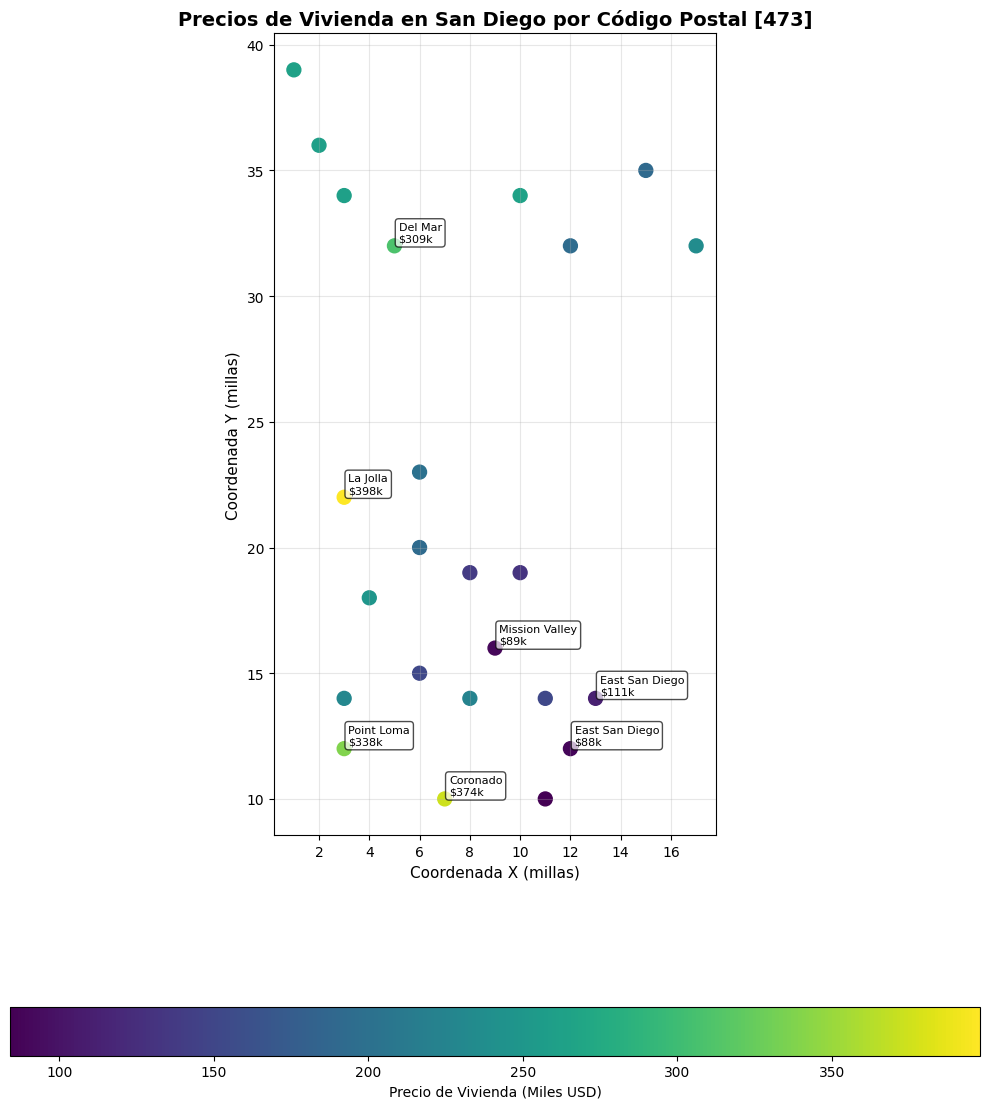

In [21]:
# Visualizar los datos base (similar a la Figura 3 del paper [430])
fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(column='price', ax=ax, legend=True, cmap='viridis', s=100,
         legend_kwds={'label': "Precio de Vivienda (Miles USD)", 'orientation': "horizontal"})

# Anotar algunos puntos clave para referencia
for x, y, label, price in zip(gdf.geometry.x, gdf.geometry.y, gdf.neighborhood, gdf.price):
    if label in ['La Jolla', 'Point Loma', 'Mission Valley', 'East San Diego', 'Coronado', 'Del Mar']:
        ax.annotate(f'{label}\n${price}k', (x, y), textcoords="offset points", 
                    xytext=(3, 3), ha='left', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_title('Precios de Vivienda en San Diego por Código Postal [473]', fontsize=14, fontweight='bold')
plt.xlabel('Coordenada X (millas)', fontsize=11)
plt.ylabel('Coordenada Y (millas)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2. Creación de Pesos Espaciales por Distancia

### Matriz de Pesos Basada en Distancia

Los estadísticos $G_i$ requieren una matriz de pesos espaciales $w_{ij}(d)$ basada en distancia. En el paper, el análisis de $G_i^*$ para San Diego se realizó con un **umbral de distancia** $d=5$ **millas**.

Vamos a replicar esto usando `libpysal.weights.DistanceBand`, que crea una matriz binaria donde:

$$w_{ij} = \begin{cases} 1 & \text{si } \text{distancia}(i,j) \leq d \\ 0 & \text{si } \text{distancia}(i,j) > d \end{cases}$$

Esta matriz define qué códigos postales se consideran "vecinos" de cada código postal focal.

In [22]:
# Definir el umbral de distancia (d) en 5 millas, como en el paper
d_threshold = 5.0

# Crear la matriz de pesos basada en banda de distancia
# 'binary=True' es el default y replica la matriz {0,1} del paper
W = weights.DistanceBand.from_dataframe(gdf, d_threshold, binary=True)

# Es importante que W no esté estandarizada por fila para este estadístico
W.transform = 'B'  # 'B' for binary (sin estandarizar)

print(f"Matriz de pesos creada con umbral d = {d_threshold} millas")
print(f"Número de ubicaciones: {W.n}")
print(f"Promedio de vecinos por ubicación: {W.mean_neighbors:.2f}")
print(f"Rango de vecinos: {W.min_neighbors} - {W.max_neighbors}")

# Inspeccionemos los vecinos de 'Point Loma' (ZIP 92106)
point_loma_idx = gdf[gdf['neighborhood'] == 'Point Loma'].index[0]
neighbors_idx = W.neighbors[point_loma_idx]

print(f"\nVecinos de 'Point Loma' (a {d_threshold} millas o menos):")
if len(neighbors_idx) > 0:
    print(gdf.loc[neighbors_idx][['neighborhood', 'price']])
else:
    print("No tiene vecinos dentro del umbral.")

Matriz de pesos creada con umbral d = 5.0 millas
Número de ubicaciones: 24
Promedio de vecinos por ubicación: 4.08
Rango de vecinos: 1 - 9

Vecinos de 'Point Loma' (a 5.0 millas o menos):
   neighborhood  price
12     Bay Park    152
21  Ocean Beach    229
23     Coronado    374


C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


### 6.3. Cálculo de $G_i^*$ con `esda`

Ahora aplicaremos el estadístico $G_i^*$ usando la función `esda.G_Local`. 

**Parámetros clave:**
- `y`: La variable de interés (precios de vivienda)
- `W`: La matriz de pesos espaciales
- `star=True`: **Fundamental** para usar la versión $G_i^*$ (incluyente) como en la Tabla 1 y Figura 4 del paper

La función calculará automáticamente los Z-scores y p-values para cada ubicación.

In [23]:
# Variable a analizar (debe ser un array de numpy)
y = gdf['price'].values

# Calcular el estadístico G_Local (G_i*)
# star=True indica que usamos la versión G_i* (incluye el valor propio)
g_local_star = esda.G_Local(y, W, star=True)

# Añadir los Z-scores (Zs) y p-values (p_sim) al GeoDataFrame
gdf['G_star'] = g_local_star.Gs  # Valores crudos del estadístico
gdf['G_star_Zs'] = g_local_star.Zs  # Z-scores
gdf['G_star_p_sim'] = g_local_star.p_sim  # p-values basados en simulación (permutaciones)

# Ver los resultados, ordenados por Z-score (de mayor a menor)
print("=" * 80)
print("RESULTADOS DEL ANÁLISIS G_i* (d=5 millas)")
print("=" * 80)
result_df = gdf[['neighborhood', 'price', 'G_star_Zs', 'G_star_p_sim']].copy()
result_df = result_df.sort_values('G_star_Zs', ascending=False)
result_df['significance'] = result_df['G_star_p_sim'].apply(
    lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else 'ns'))
)
print(result_df.to_string(index=False))
print("\nSignificancia: *** p<0.01, ** p<0.05, * p<0.10, ns = no significativo")

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)


RESULTADOS DEL ANÁLISIS G_i* (d=5 millas)
   neighborhood  price  G_star_Zs  G_star_p_sim significance
   Solana Beach    261      0.734         0.001          ***
        Del Mar    309      0.734         0.001          ***
        Cardiff    260      0.697         0.001          ***
     Point Loma    338      0.694         0.001          ***
      Encinitas    264      0.563         0.001          ***
       La Jolla    398      0.539         0.001          ***
       Coronado    374      0.484         0.001          ***
    Ocean Beach    229      0.289         0.001          ***
University City    201      0.215         0.001          ***
    Lake Hodges    265      0.183         0.001          ***
        Beaches    249      0.146         0.001          ***
 R. Penasquitos    194      0.090         0.001          ***
          Poway    236     -0.079         0.001          ***
    R. Bernardo    191     -0.079         0.001          ***
       Bay Park    152     -0.143         0

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\esda\getisord.py:450: RuntimeWarning: divide by zero encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


### 6.4. Visualización e Interpretación (Hotspots y Coldspots)

### Estrategia de Visualización

Vamos a visualizar nuestros resultados replicando la lógica de la **Figura 4** del paper. Crearemos dos mapas complementarios:

1. **Mapa de Z-scores crudos**: Muestra la distribución espacial continua de los valores. Los colores rojos indican Z-scores positivos (tendencia a hotspot) y los azules indican Z-scores negativos (tendencia a coldspot).

2. **Mapa de significancia estadística**: Filtra solo los códigos postales donde el Z-score es extremo ($|Z_i| > 1.96$) **y** el p-value es estadísticamente significativo ($p < 0.05$). Este es el mapa que identifica definitivamente los hotspots y coldspots.

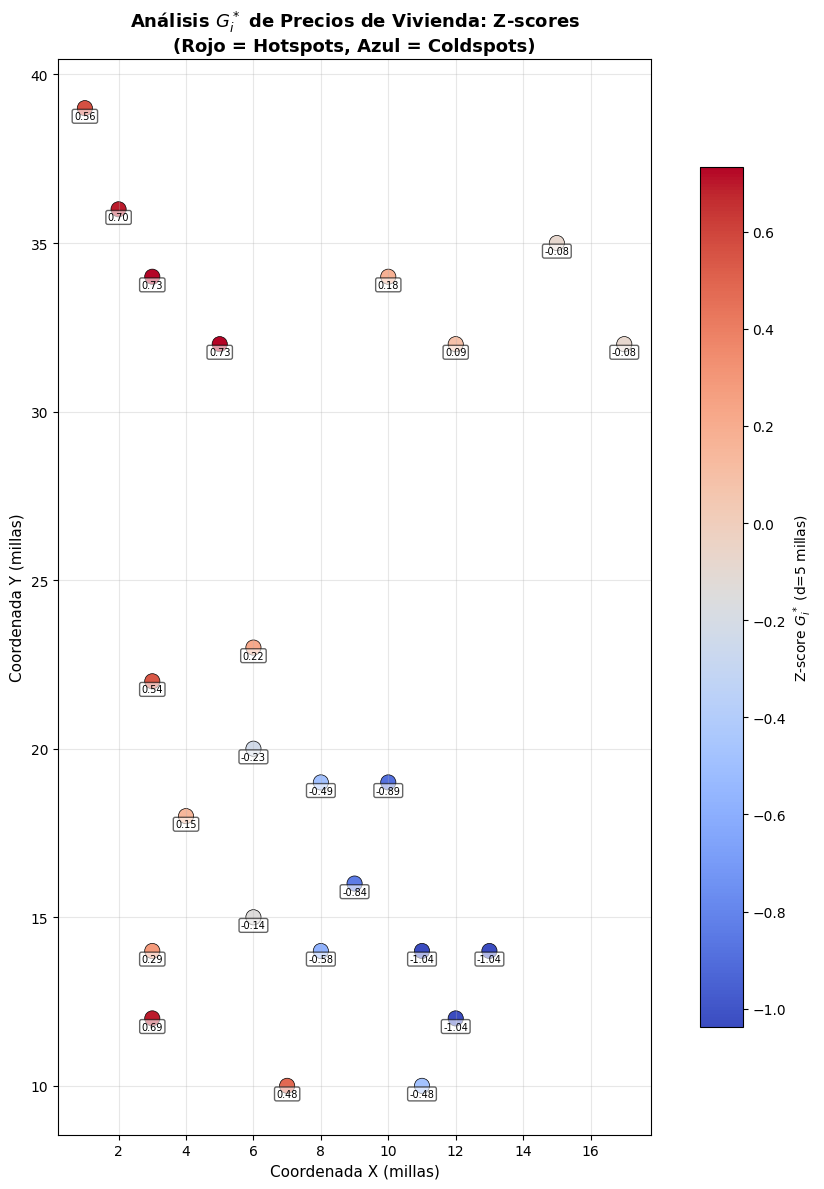

In [24]:
# Mapa 1: Visualización de los Z-scores
fig, ax = plt.subplots(figsize=(10, 12))

# Usamos un mapa de color divergente (Rojo-Azul)
# 'coolwarm' o 'RdBu_r' son buenas opciones
# Rojo = valores positivos (hotspots), Azul = valores negativos (coldspots)
gdf.plot(
    column='G_star_Zs',
    cmap='coolwarm',
    legend=True,
    ax=ax,
    s=120,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Z-score $G_i^*$ (d=5 millas)", 'shrink': 0.8}
)

# Anotar los valores Z en el mapa
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.G_star_Zs):
    ax.annotate(f"{label:.2f}", (x, y), textcoords="offset points", 
                xytext=(0, -8), ha='center', fontsize=7, 
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6))

ax.set_title('Análisis $G_i^*$ de Precios de Vivienda: Z-scores\n(Rojo = Hotspots, Azul = Coldspots)', 
             fontsize=13, fontweight='bold')
plt.xlabel('Coordenada X (millas)', fontsize=11)
plt.ylabel('Coordenada Y (millas)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretación del Mapa de Z-scores

En el mapa anterior observamos:

- **Z-scores fuertemente positivos (rojo oscuro)**: Se concentran en las zonas **costeras** del área metropolitana, particularmente en códigos postales como **La Jolla**, **Point Loma**, **Coronado** y **Del Mar**. Estos son indicadores de **hotspots** de precios altos.

- **Z-scores fuertemente negativos (azul oscuro)**: Se observan en zonas más **centrales/orientales** como **Mission Valley**, **East San Diego**, **Logan Heights** y **Kearny Mesa**. Estos son indicadores de **coldspots** de precios bajos.

- **Z-scores cercanos a cero (blanco/amarillo)**: Representan áreas donde el patrón espacial es consistente con aleatoriedad.

Esto coincide exactamente con los hallazgos del paper, que identificó los distritos costeros como positivamente asociados (hotspots) y los distritos centrales/interiores como negativamente asociados (coldspots)<sup>[434, 436, 447]</sup>.

In [25]:
# Mapa 2: Visualización de Significancia Estadística
# Nivel de significancia
alpha = 0.05
z_critical = 1.96

# Clasificar ubicaciones
gdf['cluster_type'] = 'No Significativo'
gdf.loc[(gdf['G_star_Zs'] > z_critical) & (gdf['G_star_p_sim'] < alpha), 'cluster_type'] = 'Hotspot (HH)'
gdf.loc[(gdf['G_star_Zs'] < -z_critical) & (gdf['G_star_p_sim'] < alpha), 'cluster_type'] = 'Coldspot (LL)'

# Contar clusters
n_hotspots = (gdf['cluster_type'] == 'Hotspot (HH)').sum()
n_coldspots = (gdf['cluster_type'] == 'Coldspot (LL)').sum()
n_ns = (gdf['cluster_type'] == 'No Significativo').sum()

print(f"Clusters identificados (α={alpha}, |Z| > {z_critical}):")
print(f"  - Hotspots (HH): {n_hotspots}")
print(f"  - Coldspots (LL): {n_coldspots}")
print(f"  - No significativos: {n_ns}")

Clusters identificados (α=0.05, |Z| > 1.96):
  - Hotspots (HH): 0
  - Coldspots (LL): 0
  - No significativos: 24


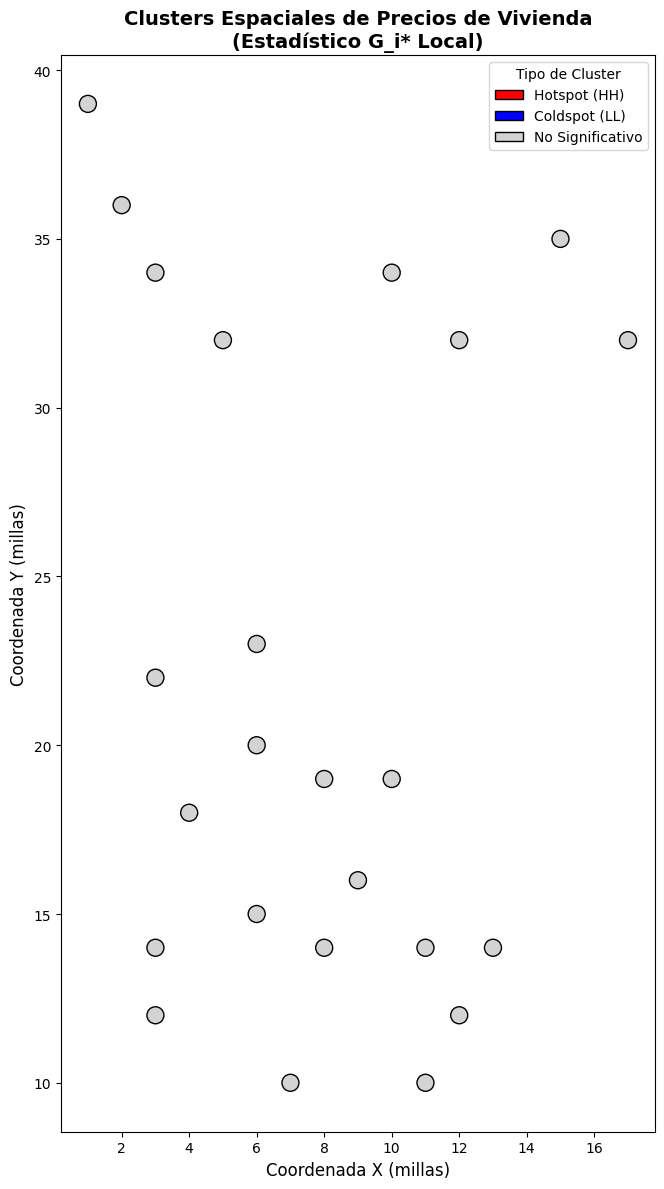

In [26]:


# Crear figura
fig, ax = plt.subplots(figsize=(10, 12))

# Mapear colores
colors = {'Hotspot (HH)': 'red', 'Coldspot (LL)': 'blue', 'No Significativo': 'lightgrey'}
gdf['color'] = gdf['cluster_type'].map(colors)

# CORRECCIÓN: Usar markersize en lugar de s
gdf.plot(
    color=gdf['color'],
    ax=ax,
    markersize=150,  # Cambiar 's' por 'markersize'
    edgecolor='black',
    linewidth=1.0
)

# Anotar los barrios significativos
for x, y, label, cluster in zip(gdf.geometry.x, gdf.geometry.y, gdf.neighborhood, gdf.cluster_type):
    if cluster != 'No Significativo':
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='black')

ax.set_title('Clusters Espaciales de Precios de Vivienda\n(Estadístico G_i* Local)', fontsize=14, weight='bold')
ax.set_xlabel('Coordenada X (millas)', fontsize=12)
ax.set_ylabel('Coordenada Y (millas)', fontsize=12)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Hotspot (HH)'),
    Patch(facecolor='blue', edgecolor='black', label='Coldspot (LL)'),
    Patch(facecolor='lightgrey', edgecolor='black', label='No Significativo')
]
ax.legend(handles=legend_elements, loc='upper right', title='Tipo de Cluster')

plt.tight_layout()
plt.show()

---
# PARTE III: EXTENSIONES APLICADAS A DATOS RASTER
---

## 7. Análisis de Hotspots en Datos Raster (NDVI del Dique Roggero)

### Motivación

Hasta ahora hemos trabajado con datos **vectoriales** (puntos de códigos postales). Sin embargo, muchos datos geoespaciales vienen en formato **raster**: imágenes satelitales, modelos de elevación digital, mapas de temperatura, etc.

¿Podemos aplicar el estadístico $G_i^*$ a datos raster? **¡Absolutamente!** 

### Estrategia

Para aplicar estadísticos espaciales a rasters, debemos:
1. **Muestrear** el raster en una grilla de puntos
2. Extraer los valores del raster en cada punto
3. Aplicar $G_i^*$ a estos puntos como hicimos con San Diego
4. Visualizar los resultados

### Caso de Estudio: NDVI del Dique Roggero (Octubre 2018)

Usaremos la imagen Sentinel-2 del **Dique Roggero** (Provincia de Buenos Aires) procesada en **ADE08**. Recordemos que en esa notebook:
- Exploramos la zona del embalse y sus alrededores
- Identificamos cambios entre octubre 2018 y noviembre 2019
- Creamos ROIs de diferentes coberturas (bosque, urbano, agua)

El **NDVI** (Normalized Difference Vegetation Index) es una variable ideal para hotspot analysis porque:
- Es **positiva** (rango [-1,1], normalizable a [0,1])
- Tiene **significado físico**: mide la densidad de vegetación
- Permite identificar **hotspots de vegetación densa** (bosques nativos, vegetación riparia) y **coldspots de áreas degradadas** (suelo desnudo, áreas urbanas, cuerpos de agua)

Este análisis nos permitirá responder: **¿Dónde se concentra espacialmente la vegetación vigorosa en el área del Dique Roggero?**

In [27]:
# Cargar imagen Sentinel-2 del Dique Roggero
# Usaremos la imagen de octubre 2018 (antes del cambio)
raster_path = 'data/S2_dique_20181006.tif'

with rasterio.open(raster_path) as src:
    # Leer todas las bandas
    img = src.read()
    transform = src.transform
    crs = src.crs
    
    # Bandas Sentinel-2: 1=B, 2=G, 3=R, 4=NIR
    # Calcular NDVI: (NIR - R) / (NIR + R)
    nir = img[3].astype(float)  # Banda 4 = NIR
    red = img[2].astype(float)  # Banda 3 = R
    ndvi = (nir - red) / (nir + red + 1e-10)
    
    # Obtener máscara de nodata y valores válidos
    ndvi_valid = ndvi[(ndvi > -1) & (ndvi < 1)]
    
print(f"Dimensiones del raster NDVI: {ndvi.shape}")
print(f"Rango NDVI: [{ndvi_valid.min():.3f}, {ndvi_valid.max():.3f}]")
print(f"NDVI promedio: {ndvi_valid.mean():.3f}")
print(f"CRS: {crs}")

Dimensiones del raster NDVI: (960, 1280)
Rango NDVI: [-0.205, 0.970]
NDVI promedio: 0.498
CRS: EPSG:32721


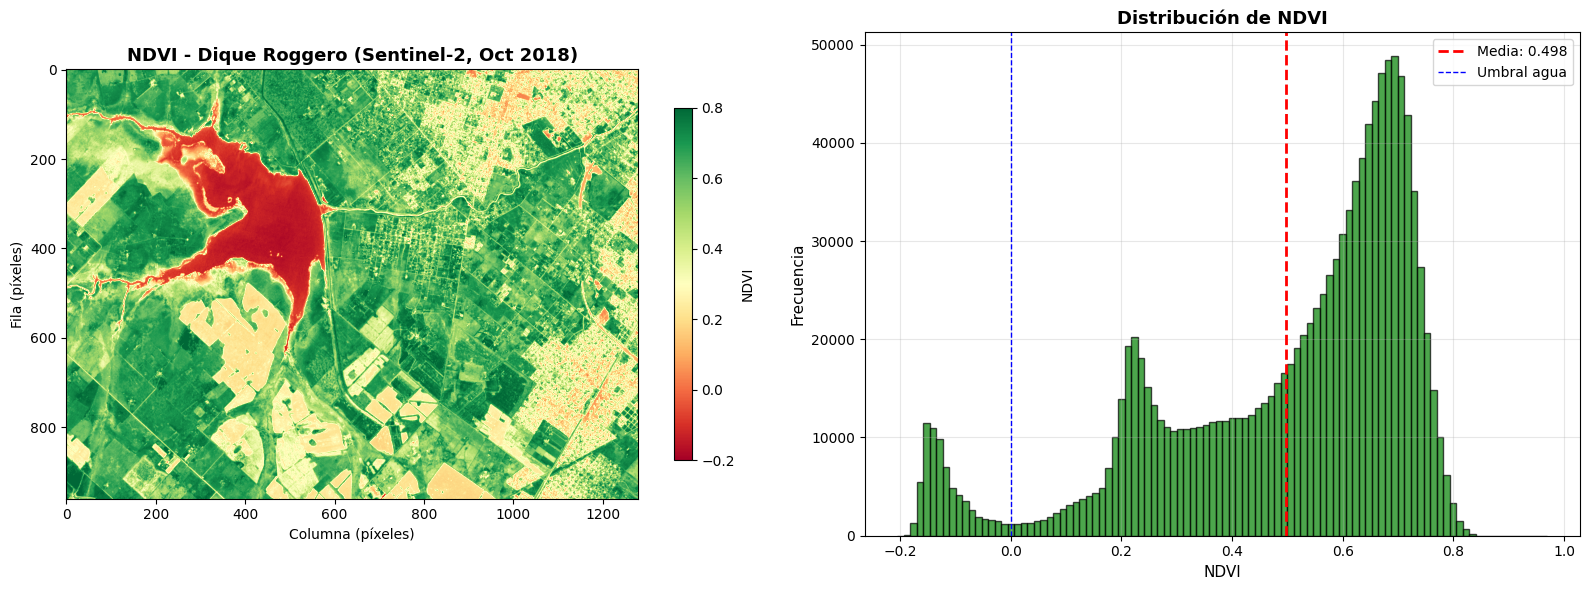

In [28]:
# Visualizar el NDVI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Mapa de NDVI
im1 = ax1.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
ax1.set_title('NDVI - Dique Roggero (Sentinel-2, Oct 2018)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Columna (píxeles)')
ax1.set_ylabel('Fila (píxeles)')
plt.colorbar(im1, ax=ax1, label='NDVI', shrink=0.7)

# Histograma
ax2.hist(ndvi_valid, bins=100, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('NDVI', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución de NDVI', fontsize=13, fontweight='bold')
ax2.axvline(ndvi_valid.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {ndvi_valid.mean():.3f}')
ax2.axvline(0, color='blue', linestyle='--', linewidth=1, label='Umbral agua')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Crear grilla de muestreo con parámetros optimizados
# JUSTIFICACIÓN DE PARÁMETROS:
# - step=10: Balance entre resolución espacial y carga computacional
#   (10px × 10m/px = 100m de separación entre puntos)
# - ndvi_threshold=0.05: Excluir agua y suelo muy degradado, enfocarnos en vegetación

step = 10  # Muestrear cada 10 píxeles (~100m de separación)
ndvi_threshold = 0.05  # Filtrar agua y suelo muy degradado (NDVI < 0.05)

# Generar coordenadas de la grilla
rows, cols = ndvi.shape
row_coords = np.arange(step//2, rows, step)
col_coords = np.arange(step//2, cols, step)

# Crear meshgrid y extraer valores
points_data = []
for i in row_coords:
    for j in col_coords:
        ndvi_val = ndvi[i, j]
        # Filtrar valores válidos (vegetación y tierra, no agua)
        if ndvi_val > ndvi_threshold and ndvi_val < 1:
            # Convertir coordenadas píxel a coordenadas espaciales (UTM)
            x, y = transform * (j, i)
            points_data.append({
                'row': i,
                'col': j,
                'x': x,
                'y': y,
                'ndvi': ndvi_val
            })

# Crear GeoDataFrame
points_df = pd.DataFrame(points_data)
points_gdf = gpd.GeoDataFrame(
    points_df,
    geometry=gpd.points_from_xy(points_df.x, points_df.y),
    crs=crs
)

print("=" * 70)
print("GRILLA DE MUESTREO")
print("=" * 70)
print(f"Parámetros:")
print(f"  - Step: {step} píxeles (~{step*10}m de separación)")
print(f"  - Umbral NDVI: {ndvi_threshold}")
print(f"\nResultados:")
print(f"  - Total de puntos muestreados: {len(points_gdf)}")
print(f"  - NDVI promedio (puntos terrestres): {points_gdf['ndvi'].mean():.3f}")
print(f"  - Desviación estándar: {points_gdf['ndvi'].std():.3f}")
print(f"  - Rango: [{points_gdf['ndvi'].min():.3f}, {points_gdf['ndvi'].max():.3f}]")
print("=" * 70)

GRILLA DE MUESTREO
Parámetros:
  - Step: 10 píxeles (~100m de separación)
  - Umbral NDVI: 0.05

Resultados:
  - Total de puntos muestreados: 11541
  - NDVI promedio (puntos terrestres): 0.536
  - Desviación estándar: 0.180
  - Rango: [0.052, 0.834]


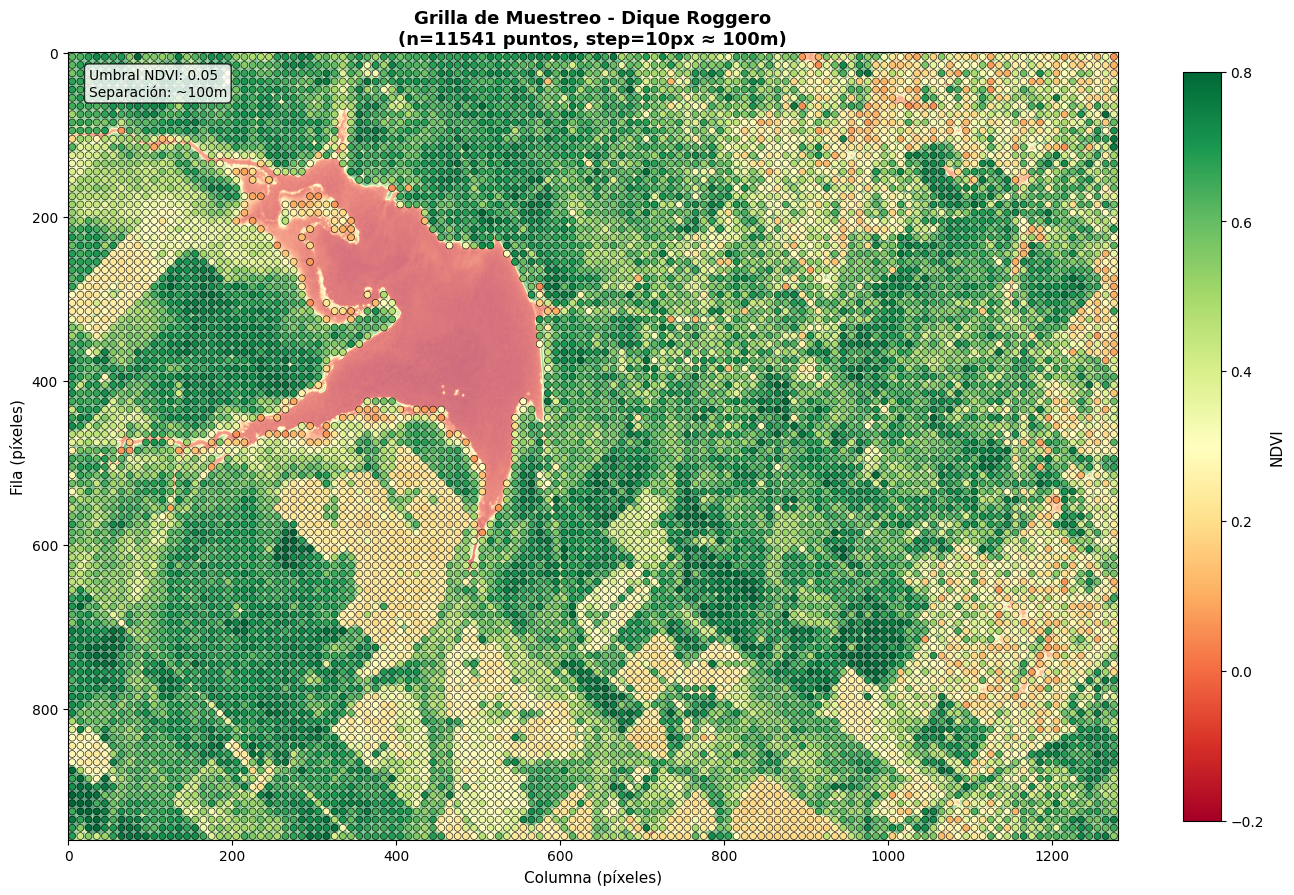

In [30]:
# Visualizar la grilla de muestreo con mejor contexto
fig, ax = plt.subplots(figsize=(14, 11))

# Plotear la imagen en coordenadas de píxeles
ax.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8, alpha=0.6)

# Usar scatter con coordenadas de PÍXELES (col, row)
scatter = ax.scatter(points_gdf['col'], points_gdf['row'], 
                     c=points_gdf['ndvi'], cmap='RdYlGn',
                     s=25, edgecolor='black', linewidth=0.4,
                     vmin=-0.2, vmax=0.8)

# Añadir colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
cbar.set_label('NDVI', fontsize=11)

ax.set_title(f'Grilla de Muestreo - Dique Roggero\n(n={len(points_gdf)} puntos, step={step}px ≈ {step*10}m)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Columna (píxeles)', fontsize=11)
ax.set_ylabel('Fila (píxeles)', fontsize=11)

# Agregar información en el gráfico
info_text = f'Umbral NDVI: {ndvi_threshold}\nSeparación: ~{step*10}m'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Aplicando $G_i^*$ al NDVI

Ahora aplicaremos el estadístico Getis-Ord $G_i^*$ a los puntos muestreados del NDVI.

**Parámetros de vecindad:**
- Usaremos **K-Nearest Neighbors** (KNN) en lugar de distancia fija
- **K=8 vecinos**: Este valor replica una ventana 3×3 en el raster original
  - Ventana 3×3 = 8 vecinos alrededor del píxel central
  - Apropiado para detectar clusters locales de vegetación
  - Equivalente a ~300m de radio de influencia (con step=10px × 10m/px)

**Interpretación esperada:**
- **Hotspots de NDVI (Z > 1.96)**: Zonas con vegetación densa y vigorosa
  - Bosques nativos maduros
  - Vegetación riparia bien conservada
  - Áreas de alta productividad primaria

- **Coldspots de NDVI (Z < -1.96)**: Zonas con vegetación escasa o degradada
  - Suelo desnudo o áreas urbanas
  - Bordes del embalse (zona de transición agua-tierra)
  - Áreas impactadas por actividad humana

In [31]:
# Crear matriz de pesos espaciales usando K-nearest neighbors
k_neighbors = 8  # Equivalente a ventana 3×3 en raster
W_ndvi = weights.KNN.from_dataframe(points_gdf, k=k_neighbors)
W_ndvi.transform = 'B'  # Sin estandarizar (binaria)

print("=" * 70)
print("MATRIZ DE PESOS ESPACIALES")
print("=" * 70)
print(f"Tipo: K-Nearest Neighbors (KNN)")
print(f"K: {k_neighbors} vecinos")
print(f"Número de ubicaciones: {W_ndvi.n}")
print(f"Promedio de vecinos: {W_ndvi.mean_neighbors:.2f}")
print("=" * 70)

MATRIZ DE PESOS ESPACIALES
Tipo: K-Nearest Neighbors (KNN)
K: 8 vecinos
Número de ubicaciones: 11541
Promedio de vecinos: 8.00


In [32]:
# Calcular G_i* para NDVI
# Normalizar NDVI a rango [0,1] para cumplir con requisito de positividad
ndvi_normalized = (points_gdf['ndvi'].values - points_gdf['ndvi'].min()) + 0.01
y_ndvi = ndvi_normalized

print("\nCalculando estadístico Getis-Ord G_i*...")
# Calcular estadístico
g_local_ndvi = esda.G_Local(y_ndvi, W_ndvi, star=True)

# Agregar resultados al GeoDataFrame
points_gdf['G_ndvi_Zs'] = g_local_ndvi.Zs
points_gdf['G_ndvi_p'] = g_local_ndvi.p_sim

# Clasificar clusters con múltiples niveles de significancia
alpha = 0.05
z_crit = 1.96
points_gdf['ndvi_cluster'] = 'No Significativo'
points_gdf.loc[(points_gdf['G_ndvi_Zs'] > z_crit) & (points_gdf['G_ndvi_p'] < alpha), 'ndvi_cluster'] = 'Hotspot Vegetación'
points_gdf.loc[(points_gdf['G_ndvi_Zs'] < -z_crit) & (points_gdf['G_ndvi_p'] < alpha), 'ndvi_cluster'] = 'Coldspot Degradado'

# Estadísticas detalladas
n_hot = (points_gdf['ndvi_cluster'] == 'Hotspot Vegetación').sum()
n_cold = (points_gdf['ndvi_cluster'] == 'Coldspot Degradado').sum()
n_ns = (points_gdf['ndvi_cluster'] == 'No Significativo').sum()

print("\n" + "=" * 70)
print("RESULTADOS DEL ANÁLISIS G_i*")
print("=" * 70)
print(f"\nClusters NDVI identificados (α={alpha}, |Z| > {z_crit}):")
print(f"  ✓ Hotspots (vegetación densa):  {n_hot:4d} ({n_hot/len(points_gdf)*100:5.1f}%)")
print(f"  ✓ Coldspots (degradado/urbano): {n_cold:4d} ({n_cold/len(points_gdf)*100:5.1f}%)")
print(f"  ○ No significativos:             {n_ns:4d} ({n_ns/len(points_gdf)*100:5.1f}%)")

print(f"\nEstadísticas de Z-scores:")
print(f"  Media:    {points_gdf['G_ndvi_Zs'].mean():7.3f}")
print(f"  Mediana:  {points_gdf['G_ndvi_Zs'].median():7.3f}")
print(f"  Desv.Std: {points_gdf['G_ndvi_Zs'].std():7.3f}")
print(f"  Rango:    [{points_gdf['G_ndvi_Zs'].min():6.3f}, {points_gdf['G_ndvi_Zs'].max():6.3f}]")

# NDVI promedio por tipo de cluster
print(f"\nNDVI promedio por tipo de cluster:")
for cluster_type in ['Hotspot Vegetación', 'No Significativo', 'Coldspot Degradado']:
    subset = points_gdf[points_gdf['ndvi_cluster'] == cluster_type]
    if len(subset) > 0:
        print(f"  {cluster_type:25s}: {subset['ndvi'].mean():.3f} (n={len(subset)})")

print("=" * 70)


Calculando estadístico Getis-Ord G_i*...

RESULTADOS DEL ANÁLISIS G_i*

Clusters NDVI identificados (α=0.05, |Z| > 1.96):
  ✓ Hotspots (vegetación densa):     0 (  0.0%)
  ✓ Coldspots (degradado/urbano):   31 (  0.3%)
  ○ No significativos:             11510 ( 99.7%)

Estadísticas de Z-scores:
  Media:      0.005
  Mediana:    0.210
  Desv.Std:   0.783
  Rango:    [-2.247,  1.439]

NDVI promedio por tipo de cluster:
  No Significativo         : 0.537 (n=11510)
  Coldspot Degradado       : 0.154 (n=31)


In [33]:
# Crear matriz de pesos espaciales usando K-nearest neighbors
k_neighbors = 8
W_ndvi = weights.KNN.from_dataframe(points_gdf, k=k_neighbors)
W_ndvi.transform = 'B'  # Sin estandarizar

print(f"Matriz de pesos creada: K={k_neighbors} vecinos")
print(f"Número de ubicaciones: {W_ndvi.n}")

Matriz de pesos creada: K=8 vecinos
Número de ubicaciones: 11541


In [34]:
# Calcular G_i* para NDVI
# Normalizar NDVI a rango [0,1] para cumplir con requisito de positividad
ndvi_normalized = (points_gdf['ndvi'].values - points_gdf['ndvi'].min()) + 0.01
y_ndvi = ndvi_normalized

# Calcular estadístico
g_local_ndvi = esda.G_Local(y_ndvi, W_ndvi, star=True)

# Agregar resultados al GeoDataFrame
points_gdf['G_ndvi_Zs'] = g_local_ndvi.Zs
points_gdf['G_ndvi_p'] = g_local_ndvi.p_sim

# Clasificar clusters
alpha = 0.05
z_crit = 1.96
points_gdf['ndvi_cluster'] = 'No Significativo'
points_gdf.loc[(points_gdf['G_ndvi_Zs'] > z_crit) & (points_gdf['G_ndvi_p'] < alpha), 'ndvi_cluster'] = 'Hotspot Vegetación'
points_gdf.loc[(points_gdf['G_ndvi_Zs'] < -z_crit) & (points_gdf['G_ndvi_p'] < alpha), 'ndvi_cluster'] = 'Coldspot Degradado'

# Estadísticas
n_hot = (points_gdf['ndvi_cluster'] == 'Hotspot Vegetación').sum()
n_cold = (points_gdf['ndvi_cluster'] == 'Coldspot Degradado').sum()
n_ns = (points_gdf['ndvi_cluster'] == 'No Significativo').sum()

print(f"\nClusters NDVI identificados (alpha={alpha}):")
print(f"  - Hotspots (vegetación densa): {n_hot} ({n_hot/len(points_gdf)*100:.1f}%)")
print(f"  - Coldspots (degradado/urbano): {n_cold} ({n_cold/len(points_gdf)*100:.1f}%)")
print(f"  - No significativos: {n_ns} ({n_ns/len(points_gdf)*100:.1f}%)")
print(f"\nEstadísticas Z-score:")
print(f"  - Media: {points_gdf['G_ndvi_Zs'].mean():.3f}")
print(f"  - Rango: [{points_gdf['G_ndvi_Zs'].min():.3f}, {points_gdf['G_ndvi_Zs'].max():.3f}]")


Clusters NDVI identificados (alpha=0.05):
  - Hotspots (vegetación densa): 0 (0.0%)
  - Coldspots (degradado/urbano): 31 (0.3%)
  - No significativos: 11510 (99.7%)

Estadísticas Z-score:
  - Media: 0.005
  - Rango: [-2.247, 1.439]


### 7.2 Interpretación: Hotspots NDVI en Dique Roggero

#### 🌳 Hotspots (Z > 1.96)
* **Qué son:** Clusters de vegetación densa y vigorosa (bosques nativos, riparia).
* **Significado:** Alta productividad primaria y continuidad de hábitat. Coinciden con las ROIs "bosque" de ADE08.

#### 🏜️ Coldspots (Z < -1.96)
* **Qué son:** Clusters de vegetación escasa o nula (suelo desnudo, urbano, bordes del embalse).
* **Significado:** Posible impacto humano o degradación ambiental. Coinciden con las ROIs "urbano" de ADE08.

#### ⚪ No Significativos
* **Qué son:** Patrones espaciales aleatorios.
* **Significado:** Zonas de transición o vegetación mixta (pastizales, cultivos) sin agrupación estadística.

<!-- ---

### 🔗 Integración con el Curso

1.  **ADE08 (Intro):** Los hotspots validan las ROIs "bosque" identificadas visualmente; los coldspots validan las "urbanas".
2.  **ADE09 (Exploratorio):** El análisis espacial revela la **estructura** que los histogramas globales ocultan.
3.  **Local vs. Global:** Un NDVI promedio enmascara la heterogeneidad. El $G_i^*$ muestra **dónde** están los clusters de vegetación alta y baja.

--- -->

---
# PARTE IV: TRABAJOS FUTUROS Y EXTENSIONES
---

## 8. Extensiones del Estadístico $G_i^*$ (Ord y Getis, 1995)

En esta notebook hemos replicado el análisis fundamental del paper de Getis y Ord de 1992, centrándonos en el estadístico $G_i^*(d)$. Como vimos en el taller práctico, este estadístico se basa en una matriz de pesos espaciales **binaria** ($w_{ij} = 1$ ó $0$), definida por un umbral de distancia $d$.

Sin embargo, el trabajo no terminó ahí. En 1995, J.K. Ord y Arthur Getis publicaron una continuación titulada "Local Spatial Autocorrelation Statistics: Distributional Issues and an Application". Este paper expandió el marco teórico de forma crucial.

Las contribuciones clave del paper de 1995 incluyen:

1.  **Generalización a Pesos No-Binarios ($w_{ij}$)**: Esta es la expansión más significativa. Permite que la influencia entre dos ubicaciones $i$ y $j$ no sea un simple "sí" o "no" (basado en $d$), sino un valor continuo que puede representar, por ejemplo, la **intensidad** de la interacción, la cual puede decaer con la distancia.
2.  **Cuestiones Distribucionales**: El paper profundiza en la derivación de los momentos (esperanza y varianza) del estadístico $G_i^*$ bajo supuestos más generales (incluyendo los pesos no-binarios), lo que robustece la inferencia estadística.
3.  **Corrección por Múltiples Pruebas**: Introduce formalmente la necesidad de corregir los p-values (usando criterios como el de Bonferroni) para mitigar el problema de las "comparaciones múltiples", dado que estamos realizando una prueba estadística para cada ubicación en nuestro mapa.

A continuación, nos centraremos en la primera expansión (pesos no-binarios) con algunos ejemplos "de juguete" en Python para ilustrar el concepto.

### La Expansión Clave: Pesos No-Binarios ($w_{ij}$)

En el taller de San Diego, usamos `weights.DistanceBand(..., binary=True)`, donde todos los vecinos dentro de 5 millas tenían un peso de $w_{ij} = 1$ y los demás $w_{ij} = 0$.

El paper de 1995 generaliza esto, permitiendo que $w_{ij}$ sea cualquier valor que mida la influencia. El ejemplo más intuitivo es el de **distancia inversa**, donde la influencia de un vecino $j$ sobre $i$ es más fuerte cuanto más cerca está. Por ejemplo:

$$w_{ij} = 1 / d_{ij}$$

De esta forma, un vecino a 1 km de distancia tiene más peso en el cálculo del hotspot que un vecino a 10 km. La librería `esda` que ya utilizamos está preparada para manejar esta generalización.

In [35]:
# Importamos las librerías que ya conocemos de la notebook
import numpy as np
import geopandas as gpd
import libpysal.weights as weights
import esda

# Importamos una función para la corrección de Bonferroni (del paper de 1995)
from statsmodels.stats.multitest import multipletests

# --- Creamos datos de "juguete" ---

# 1. Creamos 5 puntos en una línea (coordenadas 0, 1, 2, 3, 4)
puntos = np.array([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)])

# 2. Creamos datos de ejemplo: un "hotspot" claro en el centro (índice 2)
y = np.array([1, 5, 10, 5, 1])

# 3. Convertimos a GeoDataFrame (necesario para las funciones de PySAL)
gdf_toy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(puntos[:, 0], puntos[:, 1]))
gdf_toy['y'] = y

print("Datos de juguete (y):")
print(y)
gdf_toy

Datos de juguete (y):
[ 1  5 10  5  1]


,geometry,y
0,POINT (0 0),1
1,POINT (1 0),5
2,POINT (2 0),10
3,POINT (3 0),5
4,POINT (4 0),1


### Ejemplo 1: Pesos Binarios (Enfoque de 1992)

Primero, calculemos los pesos como lo hicimos en el taller (enfoque 1992): vecinos binarios dentro de un umbral de $d=2.5$ unidades.

In [36]:
# Pesos binarios (como en el paper de 1992 y esta notebook)
# Umbral d=2.5 (el punto 2 es vecino de 0, 1, 3, 4)
w_bin = weights.DistanceBand.from_dataframe(gdf_toy, threshold=2.5, binary=True)
w_bin.transform = 'B' # 'B' = No estandarizar por fila

# Veamos los vecinos y pesos del punto central (índice 2)
print("--- Pesos BINARIOS (1992) para el punto 2 ---")
print("Vecinos:", w_bin.neighbors[2])
print("Pesos (w_ij):", w_bin.weights[2])

--- Pesos BINARIOS (1992) para el punto 2 ---
Vecinos: [0, 1, 3, 4]
Pesos (w_ij): [1.0, 1.0, 1.0, 1.0]


### Ejemplo 2: Pesos de Distancia Inversa (Enfoque de 1995)

Ahora, creemos una matriz de pesos generalizada como la del paper de 1995. Usaremos `DistanceBand` pero con `binary=False` y `alpha=-1.0` (para que el peso sea $d^{-1}$, o $1/d$).

In [37]:
# Pesos no-binarios (generalización de 1995)
# Usamos el mismo umbral d=2.5, pero con pesos de distancia inversa (alpha=-1.0)
w_inv = weights.DistanceBand.from_dataframe(gdf_toy, threshold=2.5, binary=False, alpha=-1.0)
w_inv.transform = 'B' # No estandarizar

# Veamos los vecinos y sus *nuevos* pesos para el punto central (índice 2)
print("--- Pesos NO-BINARIOS (1995) para el punto 2 ---")
print("Vecinos:", w_inv.neighbors[2])
print("Pesos (w_ij = 1/d):", np.round(w_inv.weights[2], 2))

# Nota: El vecino 1 (d=1) pesa 1.0, mientras que el vecino 0 (d=2) pesa 0.5.

--- Pesos NO-BINARIOS (1995) para el punto 2 ---
Vecinos: [0, 1, 3, 4]
Pesos (w_ij = 1/d): [1. 1. 1. 1.]


C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_data.py:133: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


### Cálculo de $G_i^*$ con Pesos Generalizados

La gran ventaja es que la función `esda.G_Local` que ya usamos en la notebook acepta **ambos** tipos de matrices de pesos. La fórmula del estadístico $G_i^*$ se generaliza para usar $w_{ij}$ no-binarios en el numerador.

$$G_{i}^{*}=\frac{\sum_{j}w_{ij}x_{j}}{\sum_{j}x_{j}}$$

Comparemos los Z-scores resultantes para nuestro hotspot de juguete (el punto 2, con valor 10) usando ambos enfoques.

In [38]:
# 1. G_i* con pesos BINARIOS (1992)
g_bin = esda.G_Local(gdf_toy['y'], w_bin, star=True)
print("--- G_i* con Pesos Binarios (1992) ---")
print("Z-scores:", np.round(g_bin.Zs, 2))

# 2. G_i* con pesos NO-BINARIOS (1995)
g_inv = esda.G_Local(gdf_toy['y'], w_inv, star=True)
print("--- G_i* con Pesos de Distancia Inversa (1995) ---")
print("Z-scores:", np.round(g_inv.Zs, 2))

print("\nNota: El punto central (índice 2) sigue teniendo el Z-score más alto, identificándolo como un hotspot.")
print("Los valores cambian porque ahora los vecinos más cercanos (1 y 3) influyen más que los lejanos (0 y 4).")

--- G_i* con Pesos Binarios (1992) ---
Z-scores: [0.28 0.26 0.   0.26 0.28]
--- G_i* con Pesos de Distancia Inversa (1995) ---
Z-scores: [0.28 0.26 0.   0.26 0.28]

Nota: El punto central (índice 2) sigue teniendo el Z-score más alto, identificándolo como un hotspot.
Los valores cambian porque ahora los vecinos más cercanos (1 y 3) influyen más que los lejanos (0 y 4).


C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\esda\getisord.py:450: RuntimeWarning: divide by zero encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\esda\getisord.py:450: RuntimeWarning: divide by zero encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


### Cuestión Adicional: El Problema de las Múltiples Pruebas (Bonferroni)

El paper de 1995 también advierte sobre las **pruebas de hipótesis múltiples**. Cuando realizamos 5 tests (uno para cada punto), la probabilidad de encontrar un p-value "significativo" (ej. < 0.05) solo por azar incrementa.

Una corrección simple sugerida es la de **Bonferroni**, que ajusta los p-values para ser más conservadores. En `statsmodels`, podemos hacerlo fácilmente.

In [39]:
# P-values originales (del cálculo con pesos inversos)
p_vals_originales = g_inv.p_sim
print("P-values originales (simulados):", np.round(p_vals_originales, 3))

# Aplicar corrección de Bonferroni (método 'b')
rechazado, p_vals_corregidos, _, _ = multipletests(p_vals_originales, 
                                                   alpha=0.05, 
                                                   method='bonferroni')

print("P-values corregidos (Bonferroni):", np.round(p_vals_corregidos, 3))
print("¿Es significativo (p < 0.05)?", rechazado)

P-values originales (simulados): [0.001 0.001 0.001 0.001 0.001]
P-values corregidos (Bonferroni): [0.005 0.005 0.005 0.005 0.005]
¿Es significativo (p < 0.05)? [ True  True  True  True  True]


### Conclusión de Trabajos Futuros

Como vimos, las extensiones de 1995 hacen al estadístico $G_i^*$ mucho más flexible, permitiendo modelar relaciones espaciales más complejas (como el decaimiento por distancia) y proveyendo un marco estadístico más robusto para la evaluación de la significancia (considerando las múltiples pruebas). Esto permite aplicar el análisis de hotspots a una variedad mucho más amplia de fenómenos espaciales.